In [28]:
import numpy as np
import pandas as pd
import os
import gc
import configparser
import matplotlib.pyplot as plt
import seaborn as sns
from spectral import get_rgb, ndvi
from skimage import io

from utils.infrared import *

%matplotlib inline

pal = sns.color_palette()

import cv2

settings = configparser.ConfigParser()
settings.read('amazon.cfg')
data_dir = settings.get('data', 'data_dir')
print(data_dir)

D:/Downloads/amazon/


C:\Users\Me\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.


In [2]:
df_train = pd.read_csv(data_dir + 'train_v2.csv')
df_train.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

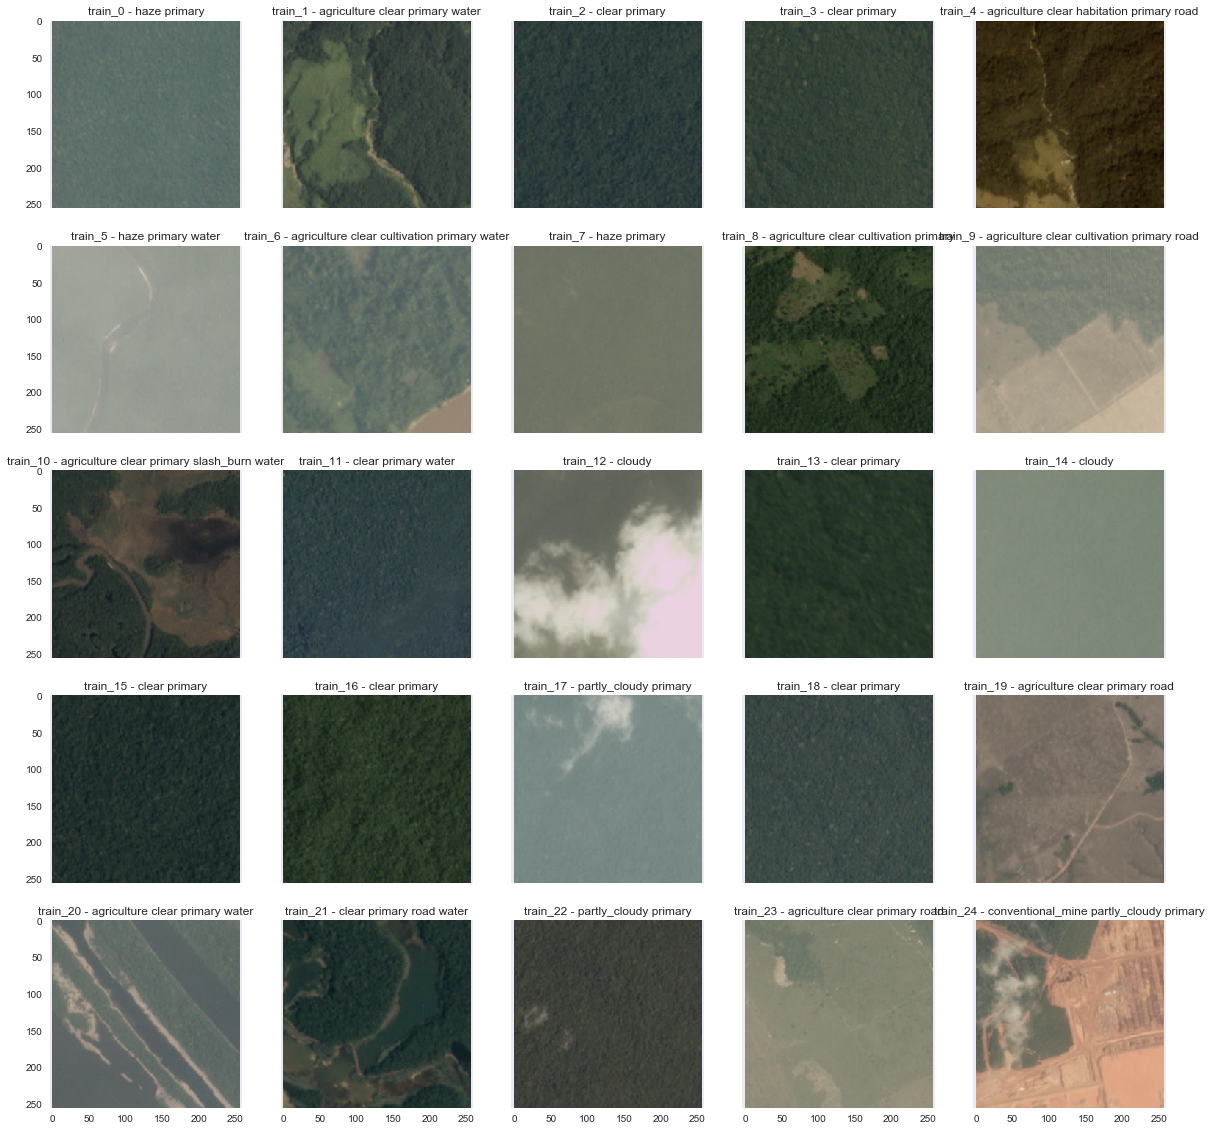

In [3]:


new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:25].values:
    img = cv2.imread(data_dir + 'train-jpg/{}.jpg'.format(f))
    ax[i // 5, i % 5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 5, i % 5].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()

In [4]:
all_tags = [item for sublist in list(df_train['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))

total of 116278 non-unique tags in all training images


In [5]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()

tag      0
12      primary  37513
5         clear  28431
0   agriculture  12315
13         road   8071
16        water   7411

In [6]:
tags_counted_and_sorted.tail()

tag    0
1      artisinal_mine  339
3            blooming  332
15         slash_burn  209
4           blow_down  101
7   conventional_mine  100

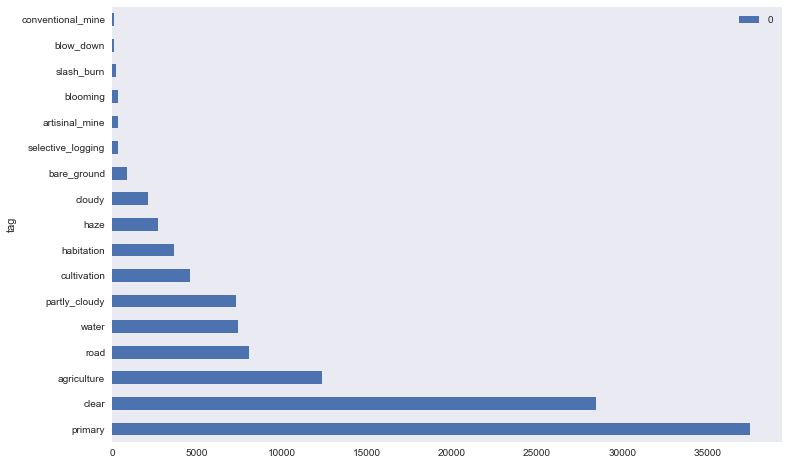

In [7]:
tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12,8))

In [8]:
# let's visualize NIR band
# not installing osgeo due to dependency conflict concern
# http://ceholden.github.io/open-geo-tutorial/python/chapter_3_visualization.html

tiff_filename = 'D:/Downloads/amazon/train-tif-sample/train_10.tif'
jpg_filename = 'D:/Downloads/amazon/train-jpg-sample/train_10.jpg'

(256L, 256L, 4L)


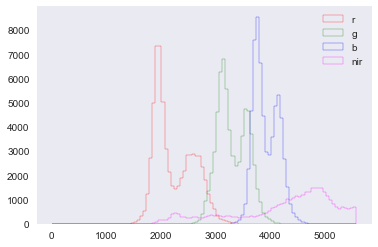

In [9]:
# equivalent ways to load an image into array using cv2 and scikit-image
#import cv2
#bgrn_image = cv2.imread(tiff_filename, cv2.IMREAD_UNCHANGED)
bgrn_image = io.imread(tiff_filename)

print(bgrn_image.shape)

# extract the rgb values
rgb_image = bgrn_image[:,:,:3]

# extract the different bands
# The tif files have not been color corrected. They are essentially what the sensor sees. Note that the band order is blue, green, red, NIR.
b, g, r, nir = bgrn_image[:, :, 0], bgrn_image[:, :, 1], bgrn_image[:, :, 2], bgrn_image[:, :, 3]

def plot_rgbn_histo(r, g, b, n):
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,rgb_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()

# plot a histogram of rgbn values
plot_rgbn_histo(r, g, b, nir)




(256L, 256L, 3L)


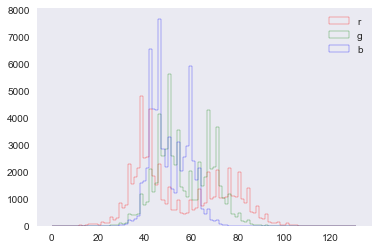

In [10]:
# proof that RGB values from JPG are different from RGB values from corresponding TIF.
# The jpgs were automatically color corrected to look "normal" to humans, taking into account the biases in our eyes. 
rgb_image = io.imread(jpg_filename)

print(rgb_image.shape)

# extract the different bands
r, g, b = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2]

def plot_rgb_histo(r, g, b):
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,rgb_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()

# plot a histogram of values
plot_rgb_histo(r, g, b)

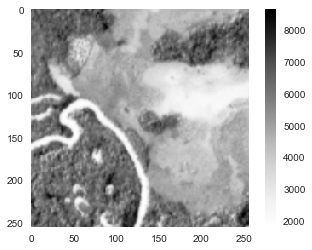

In [11]:
new_style = {'grid': False}
# visualize the NIR band
plt.imshow(bgrn_image[:, :, 3])
plt.colorbar()



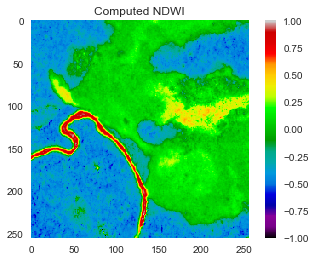

In [12]:


plt.imshow(compute_ndwi(bgrn_image), cmap=plt.get_cmap('nipy_spectral'))
plt.title('Computed NDWI')
plt.colorbar()

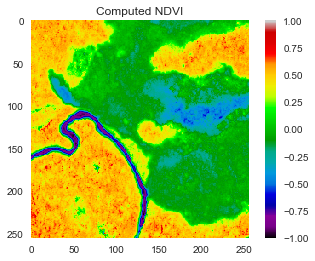

In [29]:
plt.imshow(compute_ndvi(bgrn_image), cmap=plt.get_cmap('nipy_spectral'))
plt.title('Computed NDVI')
plt.colorbar()

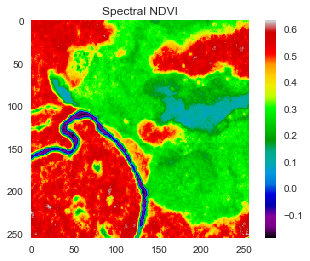

In [30]:
# spectral module ndvi function highlight better than above manually calculated compute_ndvi above.  why???
vi = spectral_ndvi(bgrn_image)
plt.imshow(vi, cmap=plt.get_cmap('nipy_spectral'))
plt.title('Spectral NDVI')
plt.colorbar()

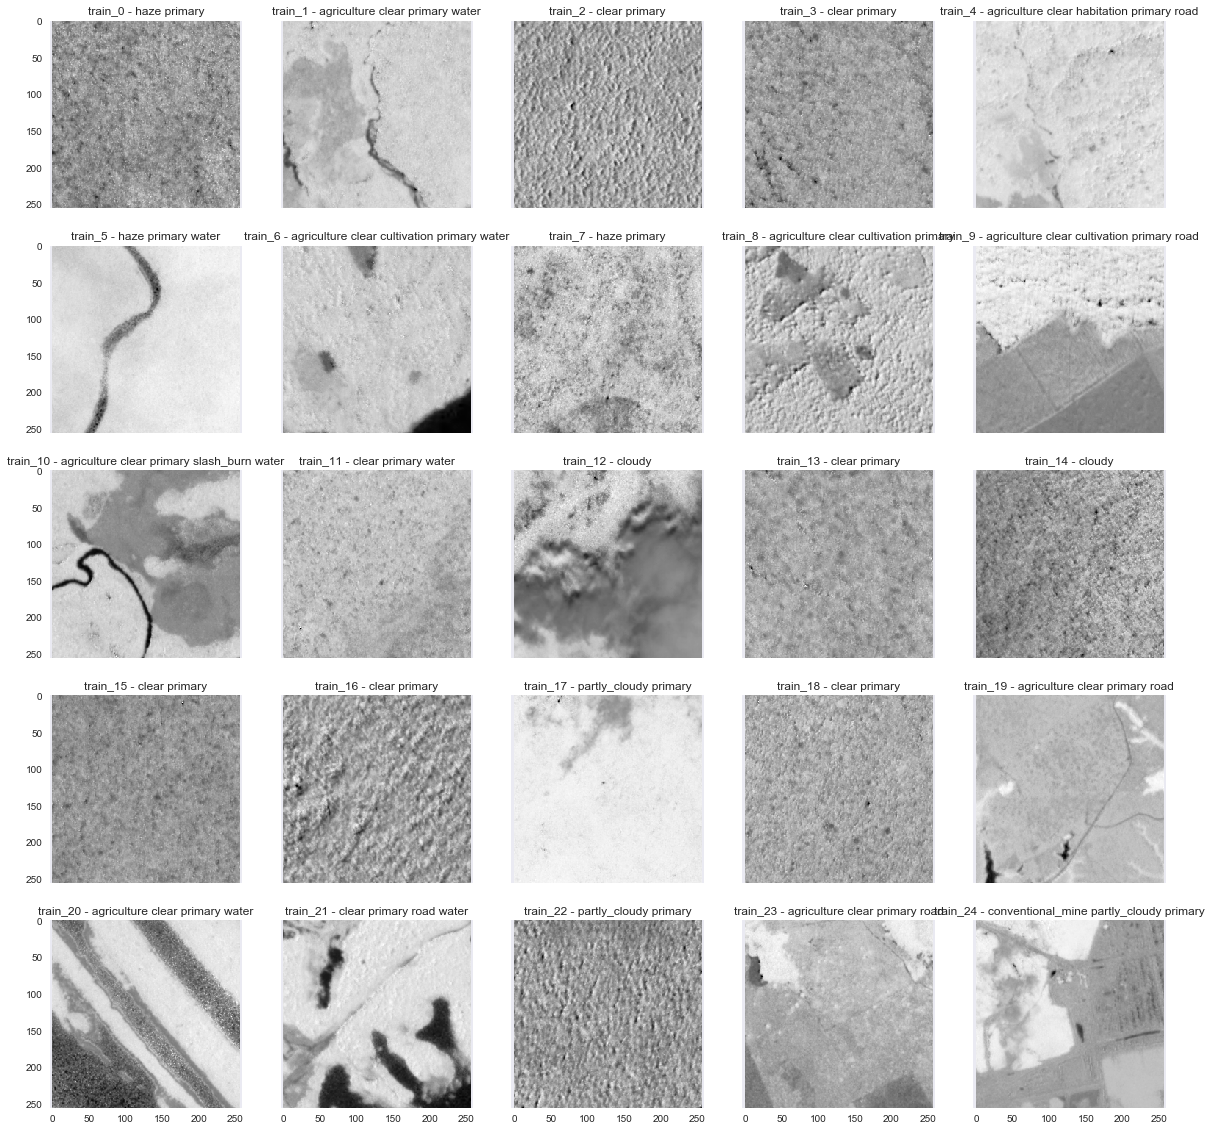

In [17]:
# NDWI with geoTIFF only.  Water is white color.
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:25].values:
    img = io.imread(data_dir + 'train-tif-v2/{}.tif'.format(f))
    ax[i // 5, i % 5].imshow(compute_ndwi(img))
    ax[i // 5, i % 5].set_title('{} - {}'.format(f, l))
    i += 1
    
plt.show()

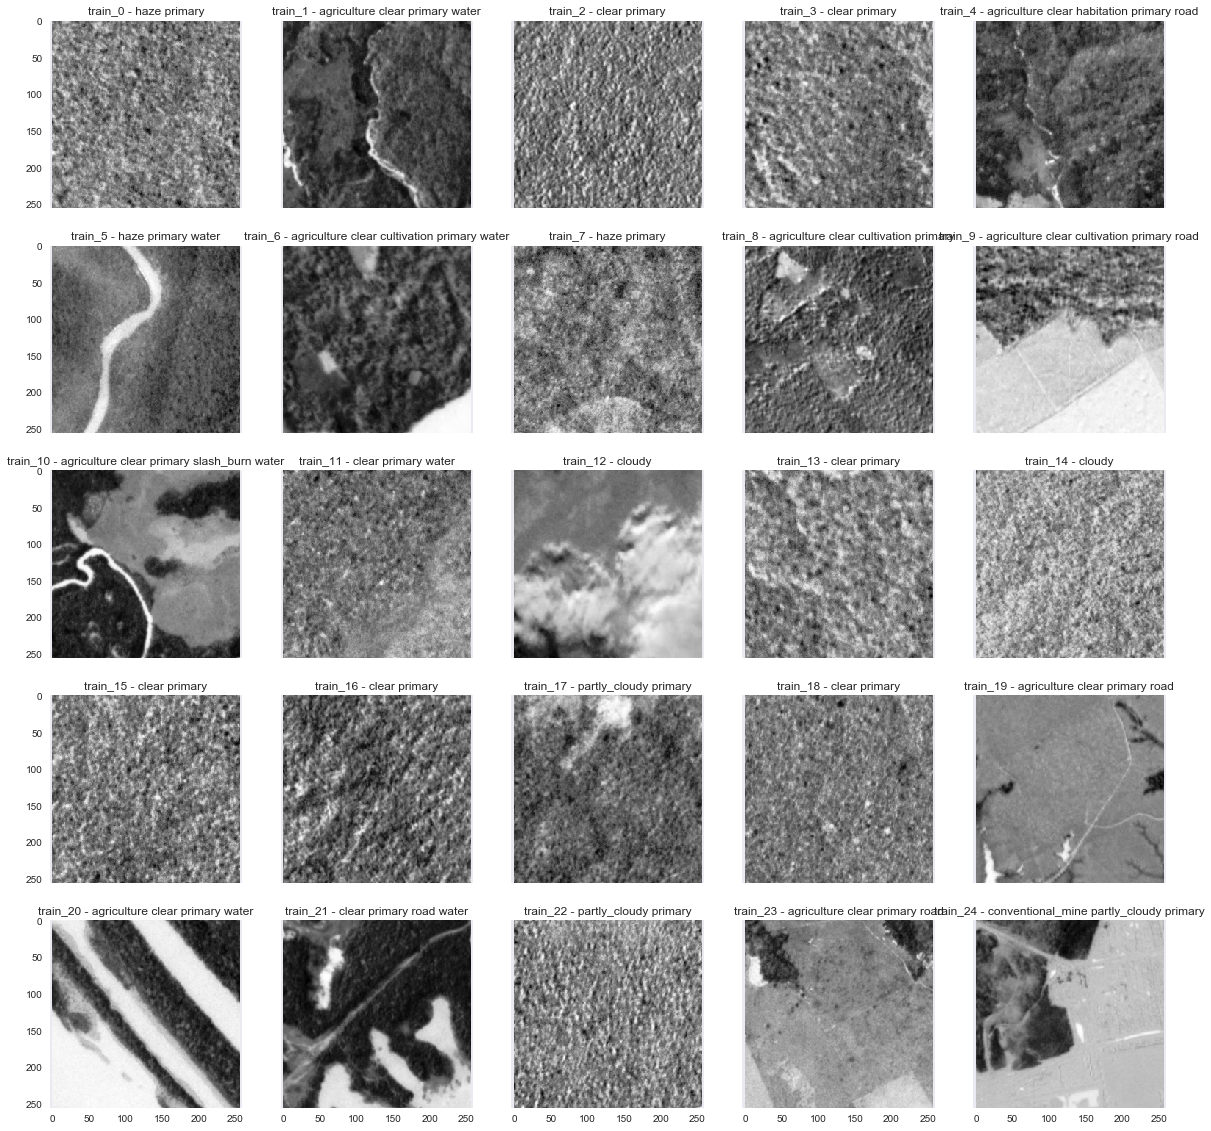

In [18]:
# vegetation NDVI
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:25].values:
    img = io.imread(data_dir + 'train-tif-v2/{}.tif'.format(f))
    ax[i // 5, i % 5].imshow(spectral_ndvi(img))
    ax[i // 5, i % 5].set_title('{} - {}'.format(f, l))
    i += 1
    
plt.show()

In [19]:
labels_df = pd.read_csv(data_dir + 'train_v2.csv')

# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
            
# Add one-hot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

In [20]:
from six import string_types

# Get a n number of samples where each sample has ALL the tags
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        #print(condition)
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]
    
print(sample_images(['water'] , n=9))

        image_name                             tags  haze  primary  \
29894  train_29894  agriculture clear primary water     0        1   
30566  train_30566              clear primary water     0        1   
1954    train_1954      partly_cloudy primary water     0        1   
24327  train_24327      partly_cloudy primary water     0        1   
36316  train_36316              clear primary water     0        1   
20712  train_20712      partly_cloudy primary water     0        1   
12460  train_12460              clear primary water     0        1   
33193  train_33193              clear primary water     0        1   
37115  train_37115         clear primary road water     0        1   

       agriculture  clear  water  habitation  road  cultivation  slash_burn  \
29894            1      1      1           0     0            0           0   
30566            0      1      1           0     0            0           0   
1954             0      0      1           0     0            

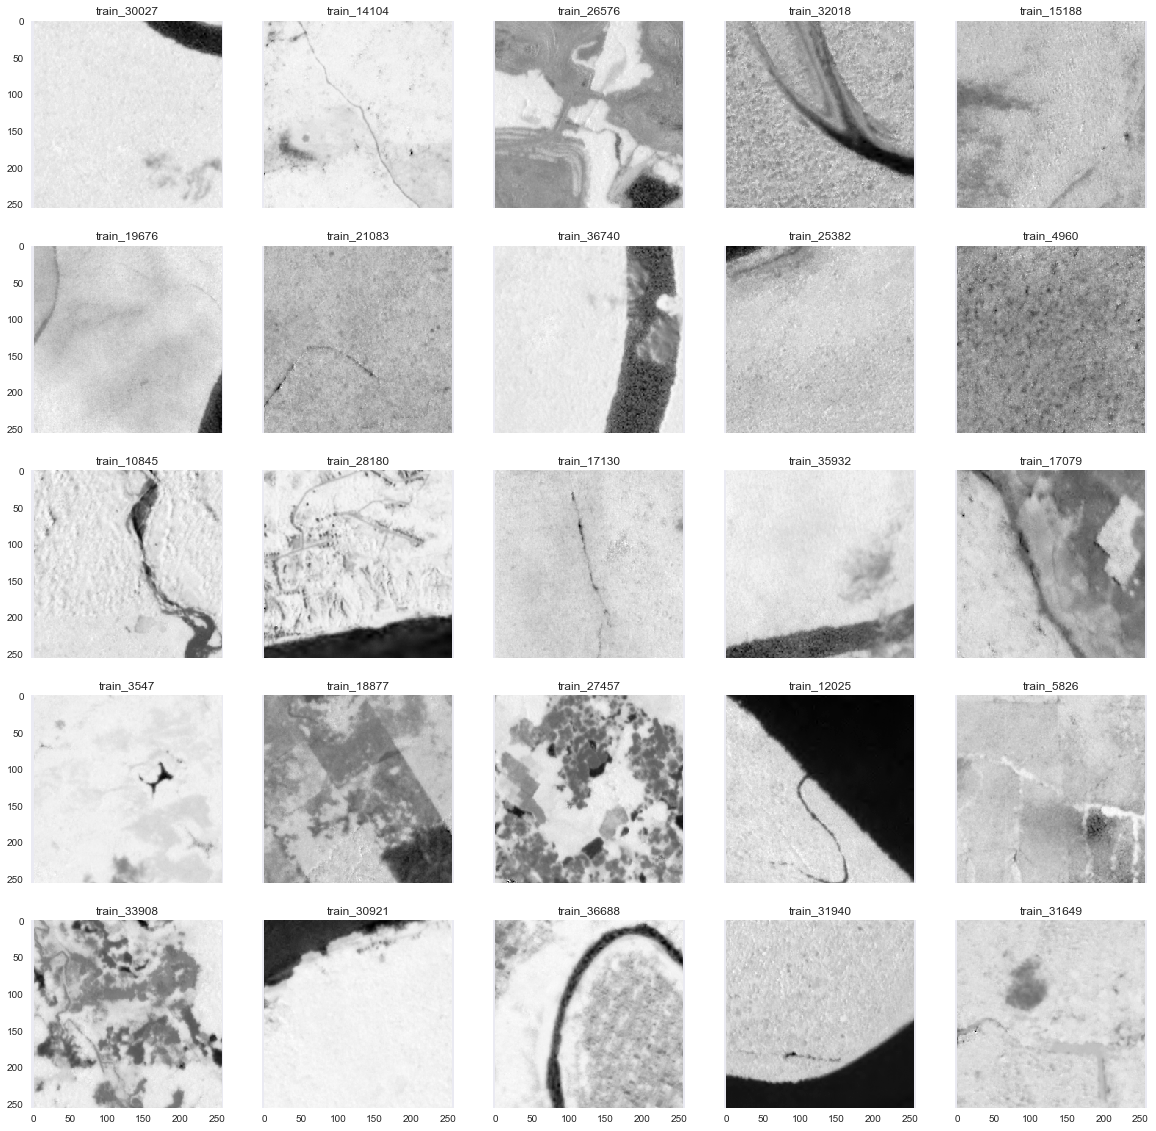

In [21]:
water_df = sample_images(['water'] , n=25)

# NDWI with geoTIFF.
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f in water_df['image_name'][:25].values:
    img = io.imread(data_dir + 'train-tif-v2/{}.tif'.format(f))
    ax[i // 5, i % 5].imshow(compute_ndwi(img))
    ax[i // 5, i % 5].set_title('{}'.format(f))
    i += 1
    
plt.show()

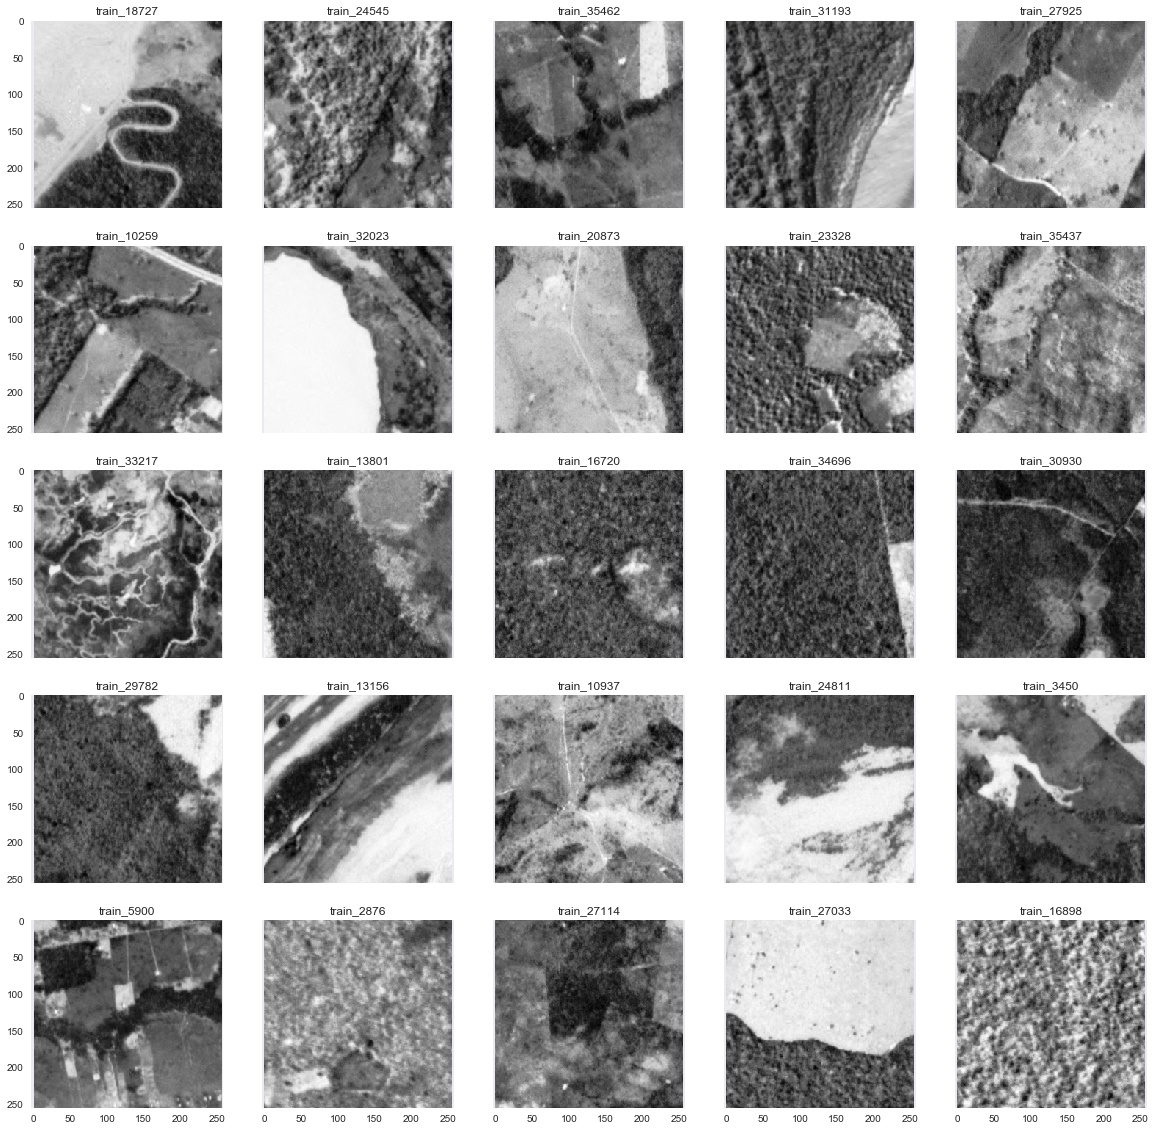

In [22]:
target_df = sample_images(['agriculture'] , n=25)

# NDVI with geoTIFF.
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f in target_df['image_name'][:25].values:
    img = io.imread(data_dir + 'train-tif-v2/{}.tif'.format(f))
    ax[i // 5, i % 5].imshow(spectral_ndvi(img))
    ax[i // 5, i % 5].set_title('{}'.format(f))
    i += 1
    
plt.show()

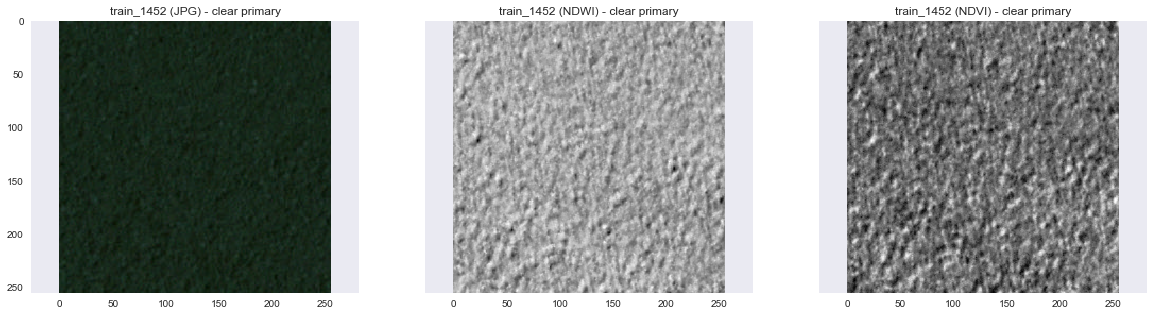

In [27]:
from random import randint

new_style = {'grid': False}
plt.rc('axes', **new_style)

index = randint(1, 10000)

f = df_train['image_name'][index]
l = df_train['tags'][index]

rgbn_img = io.imread(data_dir + 'train-tif-v2/{}.tif'.format(f))
rgb_img = io.imread(data_dir + 'train-jpg/{}.jpg'.format(f))

new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(20, 5))

ax[0].imshow(cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('{} (JPG) - {}'.format(f, l))

ax[1].imshow(compute_ndwi(rgbn_img))
ax[1].set_title('{} (NDWI) - {}'.format(f, l))

ax[2].imshow(spectral_ndvi(rgbn_img))
ax[2].set_title('{} (NDVI) - {}'.format(f, l))

plt.show()